In [1]:
using Plots,MAT,SignalAnalysis,FFTW
import DSP
FFTW.set_provider!("mkl")

In [71]:
matFn = matopen("/home/barabasz/src/tmp/fft_exercises.mat")
Freq = read(matFn,"Freq")
SamplingFreq = read(matFn,"SamplingFrequency")
matSine = read(matFn, "sinWave")
matSamples = read(matFn,"samples")
matFftOut = read(matFn,"fftOut")
matSpectrum = read(matFn,"SingleSidedSpectrum")
close(matFn)

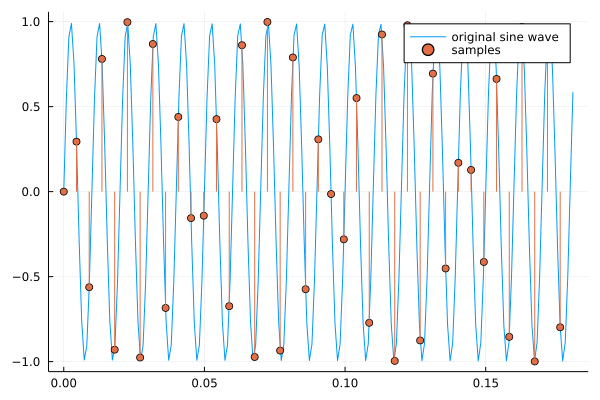

In [294]:
NumSamples=length(matSamples)
Ts=1/SamplingFreq
n=0:NumSamples-1
Tend=Ts*NumSamples
t=range(0,Tend,length=200) #num points to plot
ts=Ts*n
ω = 2*Freq*π
sine = sin.(ω*t)
samples = sin.(ω*ts)
plot(t,sine,label="original sine wave")
plot!(ts,samples,line=:stem,marker=:circle,label="samples")

In [85]:
signal_error(sig1,sig2) = abs.(sig1 - sig2).^2 |> sum;

In [86]:
err = signal_error(matSamples,samples')

8.240391742224768e-28

In [41]:
s = signal(samples,SamplingFreq)
@show energy(samples), energy(samples)/SamplingFreq
@show energy(s)

(energy(samples), energy(samples) / SamplingFreq) = (20.599833897674923, 0.0932119180890268)
energy(s) = 0.0932119180890268


0.0932119180890268

In [47]:
function signal_power(signal::Array, normed::Bool=true)
    pwr = real(sum(signal .* conj(signal)))
    if normed
        pwr /= 2*length(signal)+1
    end
    pwr  
end

signal_power (generic function with 2 methods)

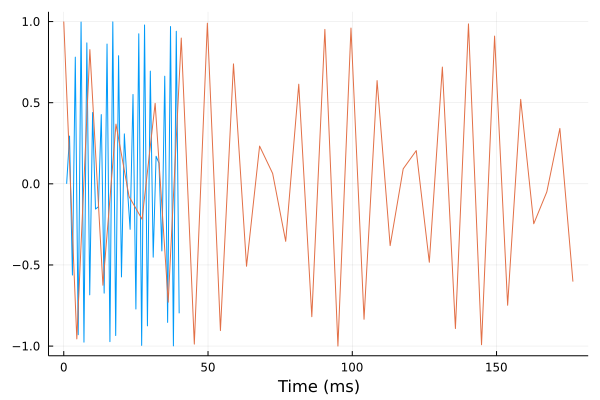

In [61]:
s2 = real(cw(Freq,Tend,SamplingFreq,phase=0))
plot(samples,label="samples")
plot!(s2,label="samples from SignalAnallysis")

In [295]:
fftOut = fft(samples')[1,:];
signal_error(fftOut,matFftOut[1,:])

3.2793934291354976e-26

In [302]:
function myFFT(signal::Array{T})::Array{Complex{T}} where {T}
    N=length(signal)
    n=0:N-1
    ωn = exp(-2π*im/N)
    fft = (ωn .^(n*n')) * signal
end

myFFT (generic function with 2 methods)

In [311]:
function myIFFT(signal::Array)
    N=length(signal)
    n=0:N-1
    ωn = exp(2π*im/N)
    fft = (ωn .^(n*n')) * signal
    fft .*= 1/N
end

myIFFT (generic function with 1 method)

In [277]:
myFftOut = myFFT(samples)
signal_error(fftOut, myFftOut)

4.881497813932006e-25

In [331]:
N=3
n=0:N-1
ωn=exp(-2π*im/N)
DFT1 = ωn .^ (n*n')
#DFT2 = cis(-2π/N*(n*n'))
#DFT1 - DFT2

3×3 Matrix{ComplexF64}:
 1.0+0.0im   1.0+0.0im        1.0+0.0im
 1.0+0.0im  -0.5-0.866025im  -0.5+0.866025im
 1.0+0.0im  -0.5+0.866025im  -0.5-0.866025im

In [293]:
test_samples = sin.(ω*Ts*0:4096);
@time fft(test_samples);
@time myFFT(test_samples);

  0.000919 seconds (36 allocations: 130.156 KiB)
  1.470712 seconds (14.17 k allocations: 385.076 MiB, 2.21% gc time, 2.03% compilation time)


In [306]:
samples_reproduced = real(ifft(fftOut));
@show size(samples_reproduced);
@show typeof(samples_reproduced);

size(samples_reproduced) = (40,)
typeof(samples_reproduced) = Vector{Float64}


In [307]:
signal_error(samples, samples_reproduced)

9.756791190921118e-31

In [312]:
samples_reproduced_2 = real(myIFFT(fftOut))
signal_error(samples,samples_reproduced_2)

1.2161521061113545e-26

In [444]:
matFn = matopen("/home/barabasz/src/tmp/fft_exercises-2.mat")
modOut = read(matFn,"modOut")
txFiltOut = read(matFn,"txFiltOut")
chanOut = read(matFn, "chanOut")
rxFiltOut = read(matFn,"rxFiltOut")
txCoeffs_ = read(matFn,"txCoeffs")
rxCoeffs = read(matFn,"rxCoeffs")
close(matFn)

In [445]:
β=0.2
SamplesPerSymbol=8
SpanInSymbols=10
txFilt = rcosfir(β,SamplesPerSymbol,SpanInSymbols);

In [446]:
txCoeffs=txCoeffs_["Numerator"][1,:];

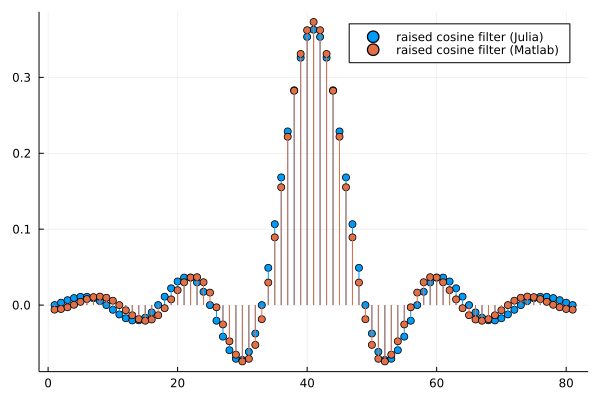

In [447]:
plot(txFilt,line=:stem,marker=:circle,label="raised cosine filter (Julia)")
plot!(txCoeffs,line=:stem,marker=:circle,label="raised cosine filter (Matlab)")

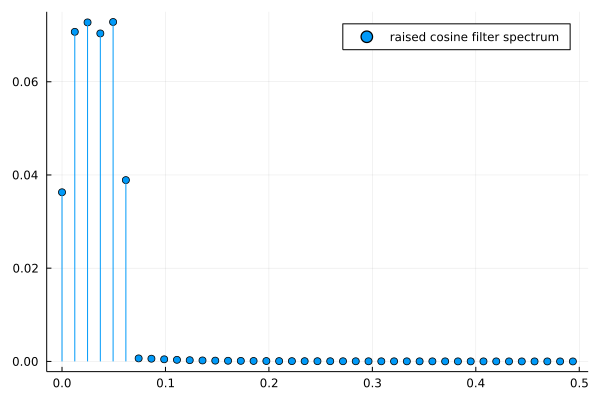

In [425]:
F = myFFT(rxFilt);
Pow = abs.(F)/length(F);
M=length(F)
Pow = Pow[1:(M÷2+1)];
Pow[2:end] = 2*Pow[2:end];
nf = (0:(M/2))/M;
plot(nf, Pow,line=:stem,marker=:circle,label="raised cosine filter spectrum")

In [452]:
txFiltOut_ = DSP.filt(txFilt, modOut)
txFiltOut_r = DSP.Filters.resample(txFiltOut_, 8;dims=1);
#@show len = min(length(txFiltOut),length(txFiltOut_))
#@show signal_error(txFiltOut[1:len],txFiltOut_[1:len]);

In [453]:
signal_diff(x,y) = abs.(x-y);

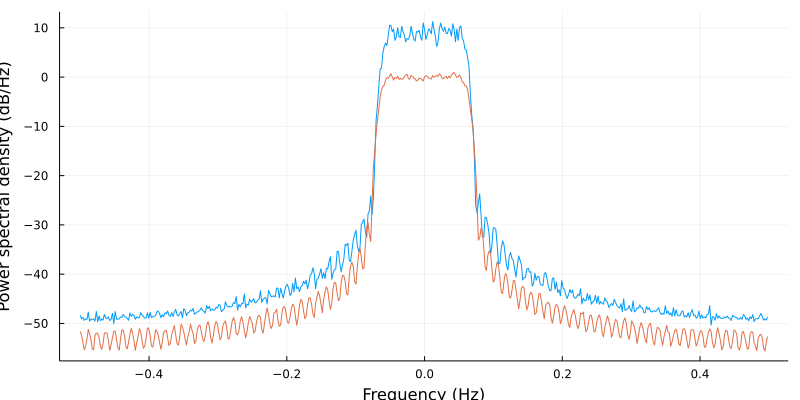

In [454]:
psd(txFiltOut_,yrange=50,size=(800,400),label="from Julia")
psd!(txFiltOut,yrange=50,size=(800,400),label="from Matlab")